In [1]:
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
import random
import math
import picos
import cvxopt
import pickle
import threadpoolctl
from krotov.parametrization import ParametrizedFunction, SquareParametrization, TanhParametrization

from discriminator import *

# Set Hyperparameters

Important: one should make sure that the number of time steps (variable of "steps" below) is reasonably larger than the annealing time $T$. This is because if one increases annealing time $T$ and fixes number of time steps, the evolution becomes more and more inaccruate. Hence, once one evolves the Hamiltonian equipped to the pulse sequences, the final state will depend on what methods one evolves the Hamiltonian. For instance, using propagator in Krotov package will give different final state from using mesolve function in Qutip package. This will make unfair to compare with the results drawn from HOQST as well. 

I checked that setting the number of steps equal to $10 \times T$ makes the evolution smooth enough so that the final states evolved from Krotov propagator and Qutip mesolve are the same.

Also, make sure you increse annealing team as you increase number of qubits.

In [2]:
nq = 2 #number of qubits
T = 5 #annealing time
steps = T*10 #time steps 
tlist = np.linspace(0, T, steps)

# Define Hamiltonian

The system Hamiltonian we will be using now is in the form of: 

$H(t) = \sum_{i=1}^{n} \epsilon_i(t) X_i + \sum_{i=1}^{n} \epsilon_{i+n}(t) Z_i - \sum_{i=1}^{n-1} Z_iZ_{i+1}, $

where $n$ is the number of qubits. In addition, we will initiaize guess control functions equipped to the initial counditions of ${\epsilon}_{i=1,...n} (t=0) = 0$ (pulse coefficients of $X_i$) and ${\epsilon}_{i=n+1,...,2n} (t=0) = 1$, which gives the ground state of $\lvert{11...11}\rangle$.

In [3]:
#set matrices for each Hamiltonian terms, X_i, Z_i, and Z_iZ_i+1
Hx_local,Hz_local,Hz_2local=[],[],[]
for i in range(nq):
    argsX=[qutip.qeye(2) for _ in range(nq)]; argsX[i]=qutip.sigmax()
    argsZ=[qutip.qeye(2) for _ in range(nq)]; argsZ[i]=qutip.sigmaz()
    Hx_local.append(qutip.tensor(*argsX)); Hz_local.append(qutip.tensor(*argsZ))
    
    if i < nq-1:
        argsZZ=[qutip.qeye(2) for _ in range(nq)]; argsZZ[i]=qutip.sigmaz(); argsZZ[i+1]=qutip.sigmaz()
        Hz_2local.append(qutip.tensor(*argsZZ))

#re-dimension
for h in Hx_local, Hz_local, Hz_2local:
    for g in h:
        g.dims=[[2**nq],[2**nq]]; 

    

In [4]:
def generate_ham(hamiltonian, pauli,k):
    if pauli == 'X':
        return [hamiltonian[k], ParametrizedFunction(lambda t, args: 0.5*np.sin(10*t/T), 
                TanhParametrization(eps_max=1.0, eps_min=-1.0))]
    elif pauli == 'Z':
        return [hamiltonian[k], ParametrizedFunction(lambda t, args: np.cos(10*t/T), 
                TanhParametrization(eps_max=1.0, eps_min=-1.0))]

In [5]:
#generate the system hamiltonian
if nq==1:
    H = [qutip.qzero(2)] + [generate_ham(Hx_local, 'X', i) for i in range(nq)] + [generate_ham(Hz_local, 'Z', i) for i in range(nq)]
else:
    H = [-Hzz for Hzz in Hz_2local] + [generate_ham(Hx_local, 'X', i) for i in range(nq)] + [generate_ham(Hz_local, 'Z', i) for i in range(nq)]

# Customize the Cost Function

This part is required if one tries to use specific forms of cost function other than listed in Krotov package(https://qucontrol.github.io/krotov/v1.0.0/API/krotov.functionals.html). 

Here, we might want to use the following form for the generator: $J_T = \lvert \text{Tr}(D\sigma-D\rho(T)) \rvert ^2$ where $\sigma=\lvert \psi_{targ} \rangle \langle \psi_{targ} \rvert$ is a target state and $\rho(T)=\lvert \psi(T) \rangle \langle \psi(T) \rvert$ is a fully time-evolved state. 

Krotov's method requires to enter $-\frac{\partial J}{\partial \langle \psi_k \rvert} = -2 (\langle \psi(T) \rvert D\lvert \psi(T)\rangle -  \langle \psi_{targ} \rvert D\lvert \psi_{targ}\rangle) \cdot D\lvert \psi(T)\rangle$, which is described in chis_qubit function below. print_qubit_error function is for print out the cost function during optimization.

In [6]:
def print_qubit_error(**args):
    """Utility function writing the qubit error to screen"""
    taus = []
    for state_T in args['fw_states_T']:
        exp = qutip.expect(D, state_T)
        taus.append(exp)
        
    J_T_re = np.average(taus)
    
    exp_D = qutip.expect(D, psi_targ)
    
    J = abs(J_T_re-exp_D)**2

    
    print("    |<psi|D|psi> - <target|D|target>|^2: %.le"% (J) )
    
    return J
        

In [7]:
def chis_qubit(fw_states_T, objectives, tau_vals):
    """Calculate chis for the chosen functional"""
    chis = []
    #print(fw_states_T)
    for state_i_T in fw_states_T:
        #print(D)
        #chi=-(D*state_i_T)
        c = qutip.expect(D, psi_targ)
        o = qutip.expect(D, state_i_T)
        
        #chi= -2*(o-c)*(D*state_i_T)
        
        chi=-2*(state_i_T.dag()*(D*state_i_T) - c)*(D*state_i_T)
        chis.append(chi)
    return chis

# Shape Function

Krotov's method requires shape function, which is used to optimize pulse sequence in each time grid. The shape function should be defined in the same time grid and indicates how much pulse value (at each time grid) is changed in a single optimization. For instance, $S(t=0) = 0$ will prevent from pulse value at $t=0$ changing. (check: https://qucontrol.github.io/krotov/v1.0.0/07_krotovs_method.html?highlight=shape%20#first-order-update)

The design of such shape function is completely up to the user.

In [8]:
def S(t):
    """Shape function for the field update"""
    #return krotov.shapes.box(t, 0, 5)
    #return krotov.shapes.blackman(t, 0, T)
    #return krotov.shapes.flattop(t, t_start=0, t_stop=T, t_rise=0.1, t_fall=0.1, func='sinsq')
    
    #return np.sin(2*np.pi*t/8)**2
    return np.sin(2*t*5/T)**2
    
    #if t==0:
    #    return 0
    
    #else:
    #    return 1

# Initial/Target States

Create initial state; here we want to start from the ground state of initial Hamiltomian we defined earlier. The ground state should be $\lvert 11..11\rangle$. 

In [9]:
#produce initial hamiltonian, i.e. H(t=0)
h0=0
for h in Hz_local,Hz_2local:
    for g in h:
        if h == Hz_local:
            h0+=g
        else:
            h0+=-g

In [10]:
psi_init = h0.eigenstates()[1][0] 
rho_init=psi_init * psi_init.dag()
psi_init

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]]

Create target states: $\lvert \psi_{target} \rangle = \cos\theta\lvert0..0\rangle + \sin\theta \lvert 1..1 \rangle$ for 50 equidistant $\theta \in [0, 2\pi]$.

In [11]:
thetas = np.linspace(0, 2*np.pi, 50)
targ_states = []
for t in thetas:
    targ_states.append(np.cos(t)*qutip.basis(2**nq,0) + np.sin(t)*qutip.basis(2**nq, 2**nq-1))

In [12]:
objectives = [krotov.Objective(initial_state=psi_init, target=0, H=H)]

# Choose initial operator for discriminator, $D_0$

Choose a random $D_0$ (initial operator for the discriminator). Here, I choose the form of $D0$ as the sum of 1-local $\cos \theta X + \sin \theta Z$ operators, i.e. $D0 = (\cos \theta_1 X + \sin \theta_1 Z) \otimes I ... \otimes I + .... + I \otimes I ... \otimes \cos \theta_n X + \sin \theta_n Z$. Then normalize $D0$ so that $||D||_p \leq 1$, depending on what types of norm you are using. 

In [13]:
phis = 2*np.pi*np.random.uniform(0,1,nq) #pick random angles

D0=0
for i in range(nq):
    ob = np.cos(phis[i])*qutip.sigmax() + np.sin(phis[i])*qutip.sigmaz()
    args=[qutip.qeye(2) for _ in range(nq)]; args[i] = ob
    D0+=qutip.tensor(qutip.tensor(*args))
    
D0.dims=[[2**nq],[2**nq]]
D0 = D0/(nq**2*np.sqrt(2)**(nq)) #preform proper normalization: this is not the optimal normalization. 
D0                           #you should check norms of D0 is actually bounded by 1 before running the optimization

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.13716178  0.10696535  0.10183954  0.        ]
 [ 0.10696535  0.00780316  0.          0.10183954]
 [ 0.10183954  0.         -0.00780316  0.10696535]
 [ 0.          0.10183954  0.10696535 -0.13716178]]

In [14]:
#check norm and make sure it's bounded by 1

print(picos.NuclearNorm(np.array(D0))) 
#print(picos.Norm(np.array(D0)))
#print(lipschitz_dual(np.array(D0)))

0.49999999999999983


In [15]:
phis

array([0.61855655, 0.54385017])

In [16]:
targ_states = [targ_states[10]]# For this notebook, I'll only train for 1 target state

In [17]:
targ_states

[Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.28452759]
  [0.        ]
  [0.        ]
  [0.95866785]]]

# Optimization

In [18]:
def kro_expm(H, state, dt, c_ops=None, backwards=False, initialize=False):
    """Propagate using matrix exponentiation.

    This supports `H` being a Hamiltonian (for a Hilbert space `state`) or a
    Liouvillian (for `state` being a density matrix) in nested-list format.
    Collapse operators `c_ops` are not supported. The propagator is not
    stateful, thus `initialize` is ignored. The matrix exponentiation is
    evaluated in single-threaded mode, to prevent accidental nested
    parallelization.
    """
    if c_ops is None:
        c_ops = []
    if len(c_ops) > 0:
        raise NotImplementedError("Liouville exponentiation not implemented")
    assert isinstance(H, list) and len(H) > 0
    eqm_factor = -1j  # factor in front of H on rhs of the equation of motion
    if isinstance(H[0], list):
        if H[0][1].type == 'super':
            eqm_factor = 1
        if backwards:
            eqm_factor = eqm_factor.conjugate()
        A = (eqm_factor * H[0][1]) * H[0][0]
    else:
        if H[0].type == 'super':
            eqm_factor = 1
        if backwards:
            eqm_factor = eqm_factor.conjugate()
        A = eqm_factor * H[0]
    for part in H[1:]:
        if isinstance(part, list):
            A += (eqm_factor * part[1]) * part[0]
        else:
            A += eqm_factor * part
    ok_types = (state.type == 'oper' and A.type == 'super') or (
        state.type in ['ket', 'bra'] and A.type == 'oper'
    )
    if ok_types:
        with threadpoolctl.threadpool_limits(limits=1):
            return ((A * dt).expm())(state)
    else:
        raise NotImplementedError(
            "Cannot handle argument types A:%s, state:%s"
            % (A.type, state.type)
        )


def trivial_evo(H, state, dt, c_ops=None, backwards=False, initialize=False):
    return state

In [18]:
#it = number of iterations taken in each step of the generator; 
#lam = stepsize of generator; #total_it: iterations of QGAN
it=1; lam =3.0; total_it = 1;

#choose norm: 'trace', 'l2', 'operator', 'w'
norm = 'trace'

In [19]:
#D, pulse, fidelity list, states
tD, tP, tF, tS = [],[],[],[]


for state in targ_states: 
    
    #set preliminaries & store initial values of D and initial pulse
    D_list,pulse_list,fid_list,state_list=[],[],[],[]
    
    #rho_list, rho_diff_list=[],[]
    
    #define target state & set initial D as D0
    psi_targ = state; rho_targ = psi_targ * psi_targ.dag(); D= D0; add=it

    #Store initial pulse & define pulse_options
    init_pulse=[]
    if nq == 1:
        pulse_options={}; H_param = [H[i][1] for i in range(1,3)]
        for h in H_param:
            pulse_options[h] = dict(lambda_a=lam, update_shape=S)
        for i in range(1,3):
            init_pulse.append(np.array([H[i][1](t, args=None) for t in tlist]))
    
    else:
        pulse_options={}; H_param = [H[i][1] for i in range(nq-1, 2*nq+(nq-1))]
        for h in H_param:
            pulse_options[h] = dict(lambda_a=lam, update_shape=S)
        for i in range(nq-1,2*nq+(nq-1)):
            init_pulse.append(np.array([H[i][1](t, args=None) for t in tlist]))
    
    D_list.append(D); pulse_list.append(init_pulse)

    
    #Generator


    for i in range(total_it):

        print(str(i)+'th step of QGAN begins')
        
        #optimize pulse

        if i == 0:
            print("About to perform krotov optim\n")
            opt_result = krotov.optimize_pulses(
            objectives,
            pulse_options,
            tlist,
            propagator=krotov.propagators.DensityMatrixODEPropagator(),
            chi_constructor=chis_qubit,
            iter_stop = it,
            info_hook=krotov.info_hooks.chain(print_qubit_error),)
            #check_convergence = krotov.convergence.value_below(limit='1e-22'))
            print("Done with Krotov")
        else:

            opt_result = krotov.optimize_pulses(
            objectives,
            pulse_options,
            tlist,
            propagator=krotov.propagators.DensityMatrixODEPropagator(),
            chi_constructor=chis_qubit,
            iter_stop = it,
            info_hook=krotov.info_hooks.chain(print_qubit_error),
            #check_convergence = krotov.convergence.value_below(limit='1e-22'),
            continue_from=opt_result)

        pulse_list.append(opt_result.optimized_controls)
        #cost_list.append(opt_result.info_vals[-1])

        final_state = opt_result.states[0] #final state
        state_list.append(final_state)

        rhot = final_state * final_state.dag() #rho_optimized

        it+=add

        #print results
        print(str(i) + 'th step finished: ' + 'psi(t) = ', final_state)

        fid_list.append(qutip.fidelity(psi_targ, final_state)**2)

        print('fidelity: ' + str(qutip.fidelity(psi_targ, final_state)**2))

        #convergence check: fidelity > 0.999
        if qutip.fidelity(psi_targ, final_state)**2 > 0.999: 
            print('converged at ' + str(i) + 'th step') 
            break

        
        #rho_list.append(rhot)
        #rho_diff_list.append(rhot-rho_targ)
        
        # Discriminator
        if norm == 'w': #when 'w' distance
            O,x =wass_distance_dual(np.array(rhot.full()),np.array(rho_targ.full()),True)
        else:
            O = discriminator(rhot.full(), rho_targ.full(), norm = norm, nq=nq)
        
        D=qutip.Qobj(O)
        D_list.append(D)

    tD.append(D_list); tP.append(pulse_list); tF.append(fid_list); tS.append(state_list)
    


0th step of QGAN begins
About to perform krotov optim



ValueError: Incorrect specification of time-dependent Liouvillian

# Results

Plot to see how pulse sequences and fidelity changed over optimization

In [22]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    Ham = ['amps of X1', 'amps of X2', 'amps of Z1', 'amps of Z2']
    for i in range(len(pulse)):
        ax.plot(tlist, pulse[i])#, label=str(Ham[i]))
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    ax.legend(Ham, bbox_to_anchor=(0.9, 0.3))
    plt.show(fig)

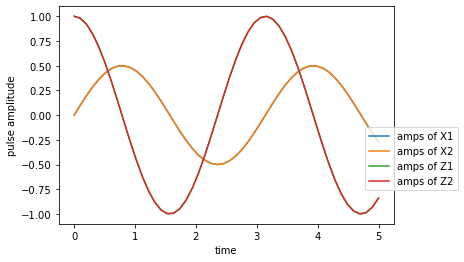

In [23]:
for i in range(len(state_list)):
    plot_pulse(pulse_list[i], tlist)

In [24]:
def plot_fid(fid_list):
    fig, ax = plt.subplots()
    f = len(fid_list)
    
    ax.plot(np.linspace(1,f, f), fid_list)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
          
    ax.set_xlabel('iteration', fontsize = 18)
    ax.set_ylabel('fidelity', fontsize = 18)
    fig.show()

In [25]:
tF #how fidelity changed

[[0.2640930671071674]]

/var/folders/2w/_70fq7w11c36fkhz8pnqp8gw0000gp/T/ipykernel_26092/3072373806.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


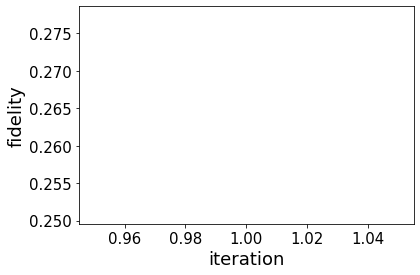

In [26]:
plot_fid(tF[0])

# Sanity Check

Check whether the state is accurate

In [29]:
opt_states = opt_result.optimized_objectives[0].propagate(tlist, propagator=krotov.propagators.expm).states

In [30]:
opt_states[-1]

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[-0.57414307+0.10383756j]
 [ 0.07566676+0.39218142j]
 [ 0.07566676+0.39218142j]
 [ 0.18088435-0.55479267j]]

In [43]:
tS[0][-1]

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]]

In [44]:
tS[0][-1]

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]]

Another way to check is whether this state is correct is by using mesolve: (mesolve might give a very slightly different state since calculation method is different: check(https://qucontrol.github.io/krotov/v1.2.0/API/krotov.propagators.html and https://qutip.org/docs/latest/apidoc/functions.html#qutip.mesolve.mesolve)

In [32]:
def generate_ham_check(hamiltonian, pauli,k,j):
    if pauli == 'X':
        return [hamiltonian[k], np.array(pulse_list[-1][j])]
    elif pauli == 'Z':
        return [hamiltonian[k], np.array(pulse_list[-1][j])]

In [33]:
H_check = [-Hzz for Hzz in Hz_2local] + \
[generate_ham_check(Hx_local, 'X', i, i) for i in range(nq)] + [generate_ham_check(Hz_local, 'Z', i, i+nq) for i in range(nq)]

In [34]:
ms = qutip.mesolve(H_check, psi_init, tlist).states[-1]
ms

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[-0.57099261+0.10672086j]
 [ 0.07476947+0.39355764j]
 [ 0.07476947+0.39355764j]
 [ 0.17993795-0.55609734j]]

In [35]:
qutip.fidelity(opt_states[-1], ms)**2 # this should be near 1

0.9999771516823452

In [37]:
opt_states[-1]

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[-0.57414307+0.10383756j]
 [ 0.07566676+0.39218142j]
 [ 0.07566676+0.39218142j]
 [ 0.18088435-0.55479267j]]

In [38]:
tS

[[Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
  Qobj data =
  [[0.]
   [0.]
   [0.]
   [1.]]]]

you can also check how discriminator's operator (D) changed over optimization

In [ ]:
tD